# Vision-Language Models (VLMs) for Cognitive Illusions

Evaluating VLM models on bistable images in order to test how similar it is to humans in processing cognitive illusions.

## Setup

### Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download images, annotations, and make results directory

In [ ]:
import os
os.makedirs('/content/drive/My Drive/independent_thesis', exist_ok=True)
results_dir = '/content/drive/My Drive/independent_thesis/results'
os.makedirs(results_dir, exist_ok=True)

In [ ]:
!gdown https://drive.google.com/uc?id=1L8Tn1bK_I_0c9YxLlXQuJCkTDlxqX90c -O "/content/drive/My Drive/independent_thesis/bistable_images.zip" # for files
!unzip "/content/drive/My Drive/independent_thesis/bistable_images.zip" -d "/content/drive/My Drive/independent_thesis/bistable_images"
!gdown https://drive.google.com/uc?id=1JXQogZHvQbSEU4GwuSAyIB0WPDGMb49y  -O "/content/drive/My Drive/independent_thesis/bistable_dataset.json" # for files


Downloading...
From: https://drive.google.com/uc?id=1L8Tn1bK_I_0c9YxLlXQuJCkTDlxqX90c
To: /content/drive/My Drive/independent_thesis/bistable_images.zip
100% 1.13M/1.13M [00:00<00:00, 125MB/s]
Archive:  /content/drive/My Drive/independent_thesis/bistable_images.zip
replace /content/drive/My Drive/independent_thesis/bistable_images/__MACOSX/._Bistable Images Original? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Downloading...
From: https://drive.google.com/uc?id=1JXQogZHvQbSEU4GwuSAyIB0WPDGMb49y
To: /content/drive/My Drive/independent_thesis/bistable_dataset.json
100% 4.43k/4.43k [00:00<00:00, 23.9MB/s]


### Set important variables

In [ ]:
import os
# TODO: make wgetable
image_dir = "/content/drive/MyDrive/independent_thesis/bistable_images/Bistable Images Original"
annotation_fname = "/content/drive/My Drive/independent_thesis/bistable_dataset.json"
os.environ['TRANSFORMERS_CACHE'] = '/content/drive/My Drive/transformers_cache'
os.environ['HF_HOME'] = '/content/drive/My Drive/transformers_cache'

### Environment Setup

In [ ]:
!python -m pip install bitsandbytes sentencepiece accelerate transformers flash-attention
!python -m pip install -i https://pypi.org/simple/ bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 39.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-man

## Data

### Scaled Image Transformations

In [ ]:
## Image Variations
from PIL import Image, ImageEnhance, ImageOps

def adjust_brightness(img, gamma=0.0):
    """
    Adjusts the brightness of an image. A factor of 0.0 gives a black image,
    a factor of 1.0 gives the original image, and a factor of 2.0 gives a
    brightened image.

    When gamma is 0.0, the image is unchanged. gamma > 0.0 increases the brightness
    of the image, and gamma < 0.0 decreases the brightness of the image. gamma is a value between -1 and 1.
    """
    factor = gamma*1.0 + 1.0
    enhancer = ImageEnhance.Brightness(img)
    enhanced_img = enhancer.enhance(1 + factor)  # Adjusting factor for Pillow's expectations
    return enhanced_img

color_options = {
    "red": (255, 0, 0),
    "green": (0, 255, 0),
    "blue": (0, 0, 255),
    "yellow": (255, 255, 0),
    "magenta": (255, 0, 255),
    "cyan": (0, 255, 255),
}

def apply_color_tint(img, color="red", gamma=0.0):
    """
    Applies a color tint to an image. The intensity of the tint is determined
    by the factor, where 0 means no tint and 1 means full tint.

    When gamma is 0.0, the image is unchanged. gamma takes values between 0 and 1.
    A value of 0.0 means no tint, and a value of 1.0 means full tint.
    """
    color = color_options.get(color)
    factor = gamma*1.0
    # Convert to RGBA to ensure it has an alpha channel
    img = img.convert("RGBA")

    # Create a tint layer with the same size as the image
    tint_layer = Image.new("RGBA", img.size, color)

    # Interpolate between the original image and the tint layer based on the factor
    tinted_img = Image.blend(img, tint_layer, factor)
    return tinted_img

def rotate_image(img, angle=0):
    """
    Rotates an image by a given angle in degrees.

    The angle parameter specifies the number of degrees by which the image is to be rotated
    counterclockwise. Positive values of angle rotate the image counterclockwise, whereas
    negative values rotate it clockwise.

    Parameters:
    img (PIL.Image): The image to rotate.
    angle (float): The angle in degrees by which the image should be rotated.

    Returns:
    PIL.Image: The rotated image.
    """
    # Rotate the image using the rotate method of PIL.Image
    rotated_img = img.rotate(angle, expand=True)  # 'expand' parameter to allow resizing to fit the whole rotated image
    return rotated_img


### Pytorch Dataset to Hold and Iterate Over the Data

In [ ]:
from torch.utils.data import Dataset
import json
import os

class BistableImageDataset(Dataset):
  """
  Dataset to hold and iterate over the bistable images.
  Arguments:
    image_dir: directory containing the images
    annotation_fname: file containing the annotations
    transform: transform to apply to the images
  """
  def __init__(self, image_dir=image_dir, annotation_fname=annotation_fname, transform=None, qa_only=False):
    self.image_dir = image_dir
    self.annotation_fname = annotation_fname
    self.qa_only  = qa_only
    self.annotations = self.load_annotations()
    self.transform = transform

  def load_annotations(self):
    with open(self.annotation_fname, 'r') as f:
      annotations = json.load(f)
    if self.qa_only:
      annotations = [annotation for annotation in annotations if 'question' in annotation]
    return annotations

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, idx):
    image_path = os.path.join(self.image_dir, self.annotations[idx]['image_id'])
    image = Image.open(image_path)
    if self.transform:
      image = self.transform(image)

    data = {
        "image": image,
        "labels": self.annotations[idx]['labels'],
        "image_id": self.annotations[idx]['image_id'],
        "synonyms": self.annotations[idx]['synonyms'],
    }

    if self.qa_only:
        data["question"] = self.annotations[idx]['question']

    return data


## Model Methods

Support for
* [CLIP](https://huggingface.co/docs/transformers/model_doc/clip)
* [IDEFICS](https://huggingface.co/docs/transformers/model_doc/idefics)
* [LLaVA](https://huggingface.co/docs/transformers/model_doc/llava)
* [MPLUGOWL]()
* [InstructBLIP](https://huggingface.co/docs/transformers/model_doc/instructblip)
* [BLIP2](https://huggingface.co/docs/transformers/model_doc/blip-2)

In [ ]:
model_to_ids = {
    "clip": ["openai/clip-vit-base-patch32", "openai/clip-vit-base-patch16", "laion/CLIP-ViT-B-32-laion2B-s34B-b79K"],
    "idefics": ["HuggingFaceM4/idefics-9b", "HuggingFaceM4/idefics-9b-instruct"],
    "llava": ["llava-hf/llava-1.5-7b-hf", "llava-hf/llava-1.5-13b-hf"],
    "mplugowl": ["MAGAer13/mplug-owl-llama-7b"],
    "instructblip": ["Salesforce/instructblip-flan-t5-xl"],
    "blip2": ["Salesforce/blip2-opt-2.7b", "Salesforce/blip2-opt-6.7b", "Salesforce/blip2-flan-t5-xl"],
  }

def get_model_type(model_id):
  """
  Get the model type from the model ID.
  """
  for model_type, model_ids in model_to_ids.items():
    if model_id in model_ids:
      return model_type
  raise ValueError(f"Model ID {model_id} not found in model_to_ids")

In [ ]:
def get_model_and_processor(model_id):
  """""
  Get the model and processor for the given model ID.
  """
  import torch
  model_type = get_model_type(model_id)
  if model_type == "clip":
    # CLIP imports
    from transformers import CLIPProcessor, CLIPModel
    # set the CLIP model
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
  elif model_type == "idefics":
    import accelerate
    import bitsandbytes
    from transformers import IdeficsForVisionText2Text, AutoProcessor, BitsAndBytesConfig

    # IDEFICS imports
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
    )

    processor = AutoProcessor.from_pretrained(model_id)

    model = IdeficsForVisionText2Text.from_pretrained(
        model_id,
        quantization_config=quantization_config,
        device_map="auto"
    )
  elif model_type == "llava":
    from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
    # Llava imports
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
    )
    model = LlavaForConditionalGeneration.from_pretrained(model_id, quantization_config=quantization_config, device_map="auto")
    processor = AutoProcessor.from_pretrained(model_id)
  elif model_type == "mplugowl":
    import os
    os.system("git clone https://github.com/X-PLUG/mPLUG-Owl.git")
    import sys
    sys.path.append("/content/mPLUG-Owl/mPLUG-Owl")
    from mplug_owl.modeling_mplug_owl import MplugOwlForConditionalGeneration
    from mplug_owl.tokenization_mplug_owl import MplugOwlTokenizer
    from mplug_owl.processing_mplug_owl import MplugOwlImageProcessor, MplugOwlProcessor
    model = MplugOwlForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image_processor = MplugOwlImageProcessor.from_pretrained(model_id)
    tokenizer = MplugOwlTokenizer.from_pretrained(model_id)
    processor = MplugOwlProcessor(image_processor, tokenizer)
  elif model_type == "instructblip":
    from transformers import InstructBlipForConditionalGeneration, InstructBlipProcessor
    import torch
    model = InstructBlipForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.float16)
    model.to("cuda" if torch.cuda.is_available() else "cpu")
    processor = InstructBlipProcessor.from_pretrained(model_id)
  elif model_type == "blip2":
    from transformers import Blip2Processor, Blip2ForConditionalGeneration
    import torch
    processor = Blip2Processor.from_pretrained(model_id)
    model = Blip2ForConditionalGeneration.from_pretrained(
        model_id, load_in_8bit=True, device_map={"": 0}, torch_dtype=torch.float16
    )  # doctest: +IGNORE_RESULT
  return model, processor

In [ ]:
def generate_from_item(item, model_id, model, processor, prompt="Describe the image.", qa=False):
  """
  Generate a text completion from the item that contains the image.
  """
  model_type = get_model_type(model_id)
  if model_type == "clip":
    raise NotImplementedError("CLIP is not implemented for generation.")

  elif model_type == "idefics":
    prompt = ["User:",
           "https://images.unsplash.com/photo-1543349689-9a4d426bee8e?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=3501&q=80",
           f"{prompt}\nAssistant: An image of the Eiffel Tower at night.\n" if not qa else f"Where was this picture taken?\nAssistant: In Paris.\n",
           "User:",
           item["image"],
           f"{prompt}\nAssistant:"
           ]

    inputs = processor(prompt, return_tensors="pt").to(model.device)
    bad_words_ids = processor.tokenizer(["<image>", "<fake_token_around_image>"], add_special_tokens=False).input_ids
    generated_ids = model.generate(**inputs, max_new_tokens=30, bad_words_ids=bad_words_ids)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

  elif model_type == "llava":
    inputs = processor(text=f"<image>\nUSER:{prompt}\nASSISTANT:", images=item["image"], return_tensors="pt").to(model.device)
    # Generate
    generate_ids = model.generate(**inputs, max_length=30)
    sentence = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    return sentence

  elif model_type == "mplugowl":
    import torch
    prompts = [
        f'''The following is a conversation between a curious human and AI assistant. The assistant gives helpful, detailed, and polite answers to the user's questions.
        Human: <image>
        Human: {prompt}.
        AI: ''']
    inputs = processor(text=prompts, images=[item["image"]], return_tensors='pt')
    inputs = {k: v.bfloat16() if v.dtype == torch.float else v for k, v in inputs.items()}
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        res = model.generate(**inputs, do_sample=False, max_length=256)
    sentence = processor.tokenizer.decode(res.tolist()[0], skip_special_tokens=True)
    return sentence

  elif model_type == "instructblip":
    inputs = processor(images=item["image"], text=prompt, return_tensors="pt").to(model.device)

    outputs = model.generate(
        **inputs,
        do_sample=False,
        num_beams=5,
        max_length=256,
        min_length=1,
        top_p=0.9,
        repetition_penalty=1.5,
        length_penalty=1.0,
        temperature=1,
    )
    generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()
    return generated_text

  elif model_type == "blip2":
    import torch
    inputs = processor(images=item["image"], text=prompt, return_tensors="pt").to(device=model.device, dtype=torch.float16)
    generated_ids = model.generate(**inputs, max_length=256)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    return generated_text

In [ ]:
def classify_from_item(item, model_id, model, processor, prompt="A photo of {}"):
  """
  Classify the image into the bistable labels.
  """
  from torch.nn.functional import softmax
  import torch

  model_type = get_model_type(model_id)
  if model_type == "clip":
    inputs = processor(text=[prompt.format(l) for l in item["labels"]], images=[item["image"]], return_tensors="pt", padding=True).to(model.device)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)
    return {l:probs[0][i].item() for i,l in enumerate(item["labels"])}

  elif model_type == "idefics":
    # TODO: issue with output, and there is not public codebase
    prompt = ["User:",
           "https://images.unsplash.com/photo-1543349689-9a4d426bee8e?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=3501&q=80",
           f"{prompt}\nChoose from:\nA. Eifel Tower\nB. Hospital\nAssistant: A\n",
           "User:",
           item["image"],
           f"{prompt}\nAssistant:"
           ]
    input_encoding = processor(prompt, return_tensors="pt").to(model.device)
    scores = torch.zeros((1, len(item["labels"])))
    for i,label in enumerate(item["labels"]):
      target_encoding = processor.tokenizer([label], return_tensors='pt', padding=False).to(model.device)
      input_len = input_encoding.input_ids.size(1)
      input_ids = torch.cat((input_encoding.input_ids, target_encoding.input_ids), dim=1)
      attention_mask = torch.cat((input_encoding.attention_mask, target_encoding.attention_mask), dim=1)
      image_attention_mask = torch.cat((input_encoding.image_attention_mask, target_encoding.attention_mask.unsqueeze(-1).repeat(1,1,input_encoding.image_attention_mask.shape[-1])), dim=1)
      target_ids = torch.cat((input_encoding.input_ids, target_encoding.input_ids), dim=1)
      target_ids[:, :input_len] = -100

      with torch.no_grad():
            outputs = model(input_ids=input_ids, labels=target_ids,attention_mask=attention_mask, pixel_values=input_encoding.pixel_values, image_attention_mask=image_attention_mask)
            scores[0, i] = -outputs.loss
    scores = scores.softmax(dim=1)
    return {l: scores[0][i].item() for i,l in enumerate(item["labels"])}

  elif model_type == "llava":
    input_encoding = processor(text=f"<image>\nUSER:{prompt}\nASSISTANT:", images=item["image"], return_tensors="pt").to(model.device)
    scores = torch.zeros((1, len(item["labels"])))
    for i,label in enumerate(item["labels"]):
      target_encoding = processor.tokenizer([label], return_tensors='pt', padding=False).to(model.device)
      input_len = input_encoding.input_ids.size(1)
      input_ids = torch.cat((input_encoding.input_ids, target_encoding.input_ids), dim=1)
      attention_mask = torch.cat((input_encoding.attention_mask, target_encoding.attention_mask), dim=1)

      target_ids = torch.cat((input_encoding.input_ids, target_encoding.input_ids), dim=1)
      target_ids[:, :input_len] = -100
      with torch.no_grad():
        outputs = model(input_ids=input_ids, labels=target_ids, attention_mask=attention_mask, pixel_values=input_encoding.pixel_values)
      scores[0, i] = -outputs.loss
    scores = scores.softmax(dim=1)
    return {l: scores[0][i].item() for i,l in enumerate(item["labels"])}

    # Generate
    generated_output = model.generate(**inputs, max_new_tokens=10, output_scores=True, return_dict=True)
    option_ids = processor.tokenizer(enumeration.values(), add_special_tokens=False).input_ids
    return {l: softmax(generated_output.scores[0][0][option_ids])[i].item() for i,l in enumerate(item["labels"])}

  elif model_type == "mplugowl":
    prompts = [
        f'''The following is a conversation between a curious human and AI assistant. The assistant gives helpful, detailed, and polite answers to the user's questions.
        Human: <image>
        Human: {prompt}\n
        AI: ''']
    input_encoding = processor(text=prompts, images=[item["image"]], return_tensors='pt')
    input_encoding = {k: v.bfloat16() if v.dtype == torch.float else v for k, v in input_encoding.items()}
    input_encoding = {k: v.to(model.device) for k, v in input_encoding.items()}
    scores = torch.zeros((1, len(item["labels"])))
    for i,label in enumerate(item["labels"]):
      target_encoding = processor.tokenizer([label], return_tensors='pt', padding=False).to(model.device)
      input_len = input_encoding['input_ids'].size(1)
      input_ids = torch.cat((input_encoding['input_ids'], target_encoding.input_ids), dim=1)
      attention_mask = torch.cat((input_encoding['attention_mask'], target_encoding.attention_mask), dim=1)

      target_ids = torch.cat((input_encoding['input_ids'], target_encoding.input_ids), dim=1)
      target_ids[:, :input_len] = -100
      with torch.no_grad():
        outputs = model(input_ids=input_ids, labels=target_ids, attention_mask=attention_mask,prompt_mask=attention_mask[:,:-1], non_padding_mask=attention_mask[:,:-1], non_media_mask=attention_mask[:,:-1], pixel_values=input_encoding['pixel_values'], num_images=torch.tensor([1]).to(model.device))
      scores[0, i] = -outputs.loss
    scores = scores.softmax(dim=1)
    return {l: scores[0][i].item() for i,l in enumerate(item["labels"])}

  elif model_type == "instructblip":
    input_encoding = processor(images=item["image"], text=prompt, return_tensors="pt").to(model.device)
    scores = torch.zeros((1, len(item["labels"])))
    for i,label in enumerate(item["labels"]):
      target_encoding = processor.tokenizer([label], return_tensors='pt', padding=False).to(model.device)
      input_len = input_encoding.input_ids.size(1)
      input_ids = torch.cat((input_encoding.input_ids, target_encoding.input_ids), dim=1)
      attention_mask = torch.cat((input_encoding.attention_mask, target_encoding.attention_mask), dim=1)

      target_ids = torch.cat((input_encoding.input_ids, target_encoding.input_ids), dim=1)
      target_ids[:, :input_len] = -100
      with torch.no_grad():
        kwargs = {k:v for k,v in input_encoding.items() if k not in ["pixel_values", "input_ids", "attention_mask"]}
        outputs = model(input_ids=input_ids, labels=target_ids, attention_mask=attention_mask, pixel_values=input_encoding['pixel_values'], **kwargs)
      scores[0, i] = -outputs.loss
    scores = scores.softmax(dim=1)
    return {l: scores[0][i].item() for i,l in enumerate(item["labels"])}


  elif model_type == "blip2":
    input_encoding = processor(images=item["image"], text=prompt, return_tensors="pt").to(device=model.device, dtype=torch.float16)
    scores = torch.zeros((1, len(item["labels"])))
    for i,label in enumerate(item["labels"]):
      target_encoding = processor.tokenizer([label], return_tensors='pt', padding=False).to(model.device)
      input_len = input_encoding.input_ids.size(1)
      input_ids = torch.cat((input_encoding.input_ids, target_encoding.input_ids), dim=1)
      attention_mask = torch.cat((input_encoding.attention_mask, target_encoding.attention_mask), dim=1)

      target_ids = torch.cat((input_encoding.input_ids, target_encoding.input_ids), dim=1)
      target_ids[:, :input_len] = -100
      with torch.no_grad():
        kwargs = {k:v for k,v in input_encoding.items() if k not in ["pixel_values", "input_ids", "attention_mask"]}
        outputs = model(input_ids=input_ids, labels=target_ids, attention_mask=attention_mask, pixel_values=input_encoding.pixel_values, **kwargs)
      scores[0, i] = -outputs.loss
    scores = scores.softmax(dim=1)
    return {l: scores[0][i].item() for i,l in enumerate(item["labels"])}



## Classification

In [ ]:
def run_experiment_classification(ds, model_id, model, processor, prompt, results_dir, exp_prefix="", show_results=True):
  import torch
  # model, processor = get_model_and_processor(model_id)
  from tqdm import tqdm
  result = {"model_id": model_id, "image_transform": "none", "prompt": prompt, "outputs": {}}
  for item in tqdm(ds):
    with torch.no_grad():
      result["outputs"][item["image_id"]] = classify_from_item(item, model_id, model, processor, prompt)
  import json
  import os
  json.dump(result, open(os.path.join(results_dir, f"{exp_prefix}{model_id.replace('/','_')}.json"), "w"))
  if show_results:
    from IPython.display import display
    for image_id, out in result["outputs"].items():
      display(Image.open(os.path.join(ds.image_dir, image_id)).resize((50, 50)))
      print({k:round(v,2) for k,v in out.items()})
  del model
  torch.cuda.empty_cache()

### Original Images

In [ ]:
import gc
import torch

### CLIP

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
100%|██████████| 29/29 [00:02<00:00, 11.50it/s]


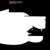

{'cat': 0.92, 'dog': 0.08}


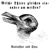

{'duck': 0.61, 'rabbit': 0.39}


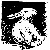

{'duck': 0.53, 'rabbit': 0.47}


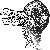

{'duck': 0.87, 'rabbit': 0.13}


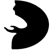

{'face grimacing': 0.24, 'begger sticking out their hands': 0.76}


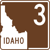

{'the state of Idaho': 1.0, 'face': 0.0}


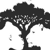

{'lion and gorilla': 0.4, 'tree': 0.6}


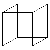

{'a cube seen from below': 0.2, 'a cube seen from above': 0.8}


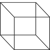

{'a cube seen from below': 0.15, 'a cube seen from above': 0.85}


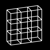

{'a cube seen from below': 0.5, 'a cube seen from above': 0.5}


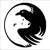

{'bird': 0.94, 'bear': 0.06}


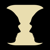

{'vase': 0.01, 'two faces': 0.99}


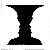

{'vase': 0.76, 'two faces': 0.24}


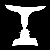

{'vase': 0.6, 'two faces': 0.4}


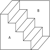

{'upright stairs': 0.71, 'sideways stairs': 0.29}


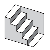

{'upright stairs': 0.89, 'sideways stairs': 0.11}


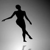

{'dancer spinning clockwise': 0.62, 'dancer spinning counter-clockwise': 0.38}


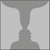

{'vase': 0.02, 'two faces': 0.98}


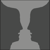

{'vase': 0.01, 'two faces': 0.99}


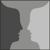

{'vase': 0.01, 'two faces': 0.99}


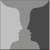

{'vase': 0.01, 'two faces': 0.99}


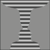

{'vase': 0.99, 'two faces': 0.01}


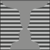

{'vase': 0.08, 'two faces': 0.92}


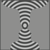

{'vase': 0.78, 'two faces': 0.22}


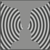

{'vase': 0.04, 'two faces': 0.96}


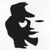

{"woman's face": 0.97, 'saxophonist': 0.03}


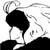

{'young woman': 0.35, 'old woman': 0.65}


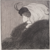

{'young woman': 0.81, 'old woman': 0.19}


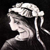

{'young woman': 0.58, 'old woman': 0.42}


100%|██████████| 29/29 [00:00<00:00, 31.33it/s]


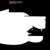

{'cat': 0.92, 'dog': 0.08}


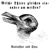

{'duck': 0.61, 'rabbit': 0.39}


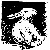

{'duck': 0.53, 'rabbit': 0.47}


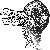

{'duck': 0.87, 'rabbit': 0.13}


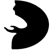

{'face grimacing': 0.24, 'begger sticking out their hands': 0.76}


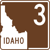

{'the state of Idaho': 1.0, 'face': 0.0}


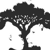

{'lion and gorilla': 0.4, 'tree': 0.6}


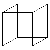

{'a cube seen from below': 0.2, 'a cube seen from above': 0.8}


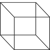

{'a cube seen from below': 0.15, 'a cube seen from above': 0.85}


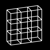

{'a cube seen from below': 0.5, 'a cube seen from above': 0.5}


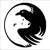

{'bird': 0.94, 'bear': 0.06}


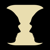

{'vase': 0.01, 'two faces': 0.99}


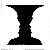

{'vase': 0.76, 'two faces': 0.24}


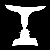

{'vase': 0.6, 'two faces': 0.4}


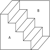

{'upright stairs': 0.71, 'sideways stairs': 0.29}


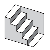

{'upright stairs': 0.89, 'sideways stairs': 0.11}


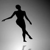

{'dancer spinning clockwise': 0.62, 'dancer spinning counter-clockwise': 0.38}


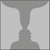

{'vase': 0.02, 'two faces': 0.98}


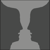

{'vase': 0.01, 'two faces': 0.99}


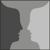

{'vase': 0.01, 'two faces': 0.99}


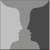

{'vase': 0.01, 'two faces': 0.99}


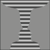

{'vase': 0.99, 'two faces': 0.01}


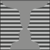

{'vase': 0.08, 'two faces': 0.92}


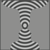

{'vase': 0.78, 'two faces': 0.22}


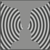

{'vase': 0.04, 'two faces': 0.96}


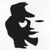

{"woman's face": 0.97, 'saxophonist': 0.03}


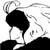

{'young woman': 0.35, 'old woman': 0.65}


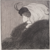

{'young woman': 0.81, 'old woman': 0.19}


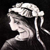

{'young woman': 0.58, 'old woman': 0.42}


100%|██████████| 29/29 [00:00<00:00, 31.59it/s]


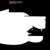

{'cat': 0.92, 'dog': 0.08}


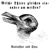

{'duck': 0.61, 'rabbit': 0.39}


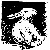

{'duck': 0.53, 'rabbit': 0.47}


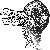

{'duck': 0.87, 'rabbit': 0.13}


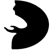

{'face grimacing': 0.24, 'begger sticking out their hands': 0.76}


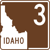

{'the state of Idaho': 1.0, 'face': 0.0}


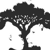

{'lion and gorilla': 0.4, 'tree': 0.6}


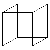

{'a cube seen from below': 0.2, 'a cube seen from above': 0.8}


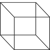

{'a cube seen from below': 0.15, 'a cube seen from above': 0.85}


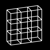

{'a cube seen from below': 0.5, 'a cube seen from above': 0.5}


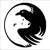

{'bird': 0.94, 'bear': 0.06}


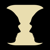

{'vase': 0.01, 'two faces': 0.99}


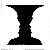

{'vase': 0.76, 'two faces': 0.24}


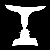

{'vase': 0.6, 'two faces': 0.4}


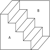

{'upright stairs': 0.71, 'sideways stairs': 0.29}


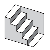

{'upright stairs': 0.89, 'sideways stairs': 0.11}


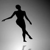

{'dancer spinning clockwise': 0.62, 'dancer spinning counter-clockwise': 0.38}


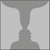

{'vase': 0.02, 'two faces': 0.98}


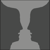

{'vase': 0.01, 'two faces': 0.99}


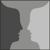

{'vase': 0.01, 'two faces': 0.99}


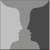

{'vase': 0.01, 'two faces': 0.99}


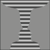

{'vase': 0.99, 'two faces': 0.01}


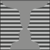

{'vase': 0.08, 'two faces': 0.92}


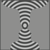

{'vase': 0.78, 'two faces': 0.22}


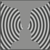

{'vase': 0.04, 'two faces': 0.96}


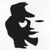

{"woman's face": 0.97, 'saxophonist': 0.03}


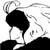

{'young woman': 0.35, 'old woman': 0.65}


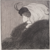

{'young woman': 0.81, 'old woman': 0.19}


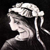

{'young woman': 0.58, 'old woman': 0.42}


In [ ]:
for model_id in ["openai/clip-vit-base-patch32", "openai/clip-vit-base-patch16", "laion/CLIP-ViT-B-32-laion2B-s34B-b79K"]:
  gc.collect()
  torch. cuda.empty_cache()
  ds = BistableImageDataset()
  prompt = "A photo of {}"
  exp_prefix = "original_images_"
  model, processor = get_model_and_processor(model_id)
  run_experiment_classification(ds, model_id, model, processor, prompt, results_dir, exp_prefix=exp_prefix)

### LLaVA

/usr/local/lib/python3.10/dist-packages/transformers/models/llava/configuration_llava.py:103: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 29/29 [00:08<00:00,  3.28it/s]


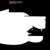

{'cat': 0.52, 'dog': 0.48}


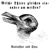

{'duck': 0.54, 'rabbit': 0.46}


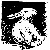

{'duck': 0.53, 'rabbit': 0.47}


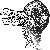

{'duck': 0.54, 'rabbit': 0.46}


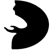

{'face grimacing': 0.1, 'begger sticking out their hands': 0.9}


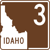

{'the state of Idaho': 1.0, 'face': 0.0}


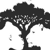

{'lion and gorilla': 1.0, 'tree': 0.0}


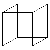

{'a cube seen from below': 0.4, 'a cube seen from above': 0.6}


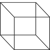

{'a cube seen from below': 0.42, 'a cube seen from above': 0.58}


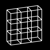

{'a cube seen from below': 0.43, 'a cube seen from above': 0.57}


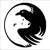

{'bird': 0.39, 'bear': 0.61}


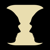

{'vase': 0.34, 'two faces': 0.66}


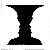

{'vase': 0.58, 'two faces': 0.42}


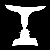

{'vase': 0.46, 'two faces': 0.54}


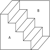

{'upright stairs': 0.79, 'sideways stairs': 0.21}


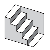

{'upright stairs': 0.82, 'sideways stairs': 0.18}


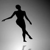

{'dancer spinning clockwise': 0.2, 'dancer spinning counter-clockwise': 0.8}


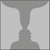

{'vase': 0.41, 'two faces': 0.59}


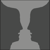

{'vase': 0.31, 'two faces': 0.69}


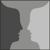

{'vase': 0.29, 'two faces': 0.71}


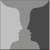

{'vase': 0.29, 'two faces': 0.71}


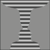

{'vase': 0.29, 'two faces': 0.71}


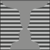

{'vase': 0.35, 'two faces': 0.65}


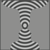

{'vase': 0.31, 'two faces': 0.69}


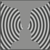

{'vase': 0.32, 'two faces': 0.68}


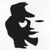

{"woman's face": 0.46, 'saxophonist': 0.54}


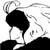

{'young woman': 0.49, 'old woman': 0.51}


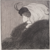

{'young woman': 0.54, 'old woman': 0.46}


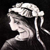

{'young woman': 0.53, 'old woman': 0.47}


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 29/29 [00:10<00:00,  2.72it/s]


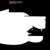

{'cat': 0.52, 'dog': 0.48}


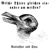

{'duck': 0.65, 'rabbit': 0.35}


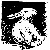

{'duck': 0.65, 'rabbit': 0.35}


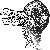

{'duck': 0.72, 'rabbit': 0.28}


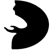

{'face grimacing': 0.16, 'begger sticking out their hands': 0.84}


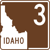

{'the state of Idaho': 1.0, 'face': 0.0}


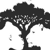

{'lion and gorilla': 1.0, 'tree': 0.0}


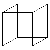

{'a cube seen from below': 0.42, 'a cube seen from above': 0.58}


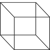

{'a cube seen from below': 0.43, 'a cube seen from above': 0.57}


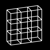

{'a cube seen from below': 0.42, 'a cube seen from above': 0.58}


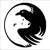

{'bird': 0.58, 'bear': 0.42}


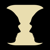

{'vase': 0.47, 'two faces': 0.53}


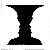

{'vase': 0.55, 'two faces': 0.45}


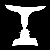

{'vase': 0.46, 'two faces': 0.54}


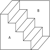

{'upright stairs': 0.72, 'sideways stairs': 0.28}


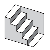

{'upright stairs': 0.72, 'sideways stairs': 0.28}


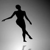

{'dancer spinning clockwise': 0.23, 'dancer spinning counter-clockwise': 0.77}


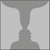

{'vase': 0.49, 'two faces': 0.51}


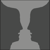

{'vase': 0.43, 'two faces': 0.57}


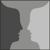

{'vase': 0.43, 'two faces': 0.57}


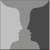

{'vase': 0.43, 'two faces': 0.57}


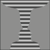

{'vase': 0.47, 'two faces': 0.53}


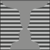

{'vase': 0.47, 'two faces': 0.53}


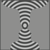

{'vase': 0.5, 'two faces': 0.5}


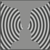

{'vase': 0.54, 'two faces': 0.46}


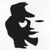

{"woman's face": 0.26, 'saxophonist': 0.74}


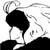

{'young woman': 0.46, 'old woman': 0.54}


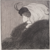

{'young woman': 0.51, 'old woman': 0.49}


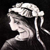

{'young woman': 0.51, 'old woman': 0.49}


In [ ]:
for model_id in ["llava-hf/llava-1.5-7b-hf", "llava-hf/llava-1.5-13b-hf"]:
  gc.collect()
  torch. cuda.empty_cache()
  ds = BistableImageDataset()
  prompt = "A photo of "
  exp_prefix = "original_images_"
  model, processor = get_model_and_processor(model_id)
  run_experiment_classification(ds, model_id, model, processor, prompt, results_dir, exp_prefix=exp_prefix)

###Idefics

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:42<00:00,  1.45s/it]


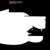

{'cat': 0.54, 'dog': 0.46}


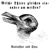

{'duck': 0.61, 'rabbit': 0.39}


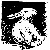

{'duck': 0.69, 'rabbit': 0.31}


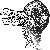

{'duck': 0.74, 'rabbit': 0.26}


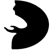

{'face grimacing': 0.25, 'begger sticking out their hands': 0.75}


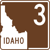

{'the state of Idaho': 1.0, 'face': 0.0}


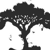

{'lion and gorilla': 1.0, 'tree': 0.0}


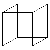

{'a cube seen from below': 0.38, 'a cube seen from above': 0.62}


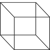

{'a cube seen from below': 0.39, 'a cube seen from above': 0.61}


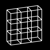

{'a cube seen from below': 0.4, 'a cube seen from above': 0.6}


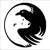

{'bird': 0.52, 'bear': 0.48}


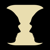

{'vase': 0.29, 'two faces': 0.71}


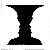

{'vase': 0.38, 'two faces': 0.62}


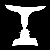

{'vase': 0.32, 'two faces': 0.68}


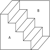

{'upright stairs': 0.88, 'sideways stairs': 0.12}


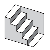

{'upright stairs': 0.87, 'sideways stairs': 0.13}


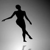

{'dancer spinning clockwise': 0.23, 'dancer spinning counter-clockwise': 0.77}


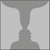

{'vase': 0.51, 'two faces': 0.49}


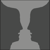

{'vase': 0.34, 'two faces': 0.66}


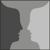

{'vase': 0.39, 'two faces': 0.61}


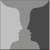

{'vase': 0.41, 'two faces': 0.59}


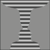

{'vase': 0.42, 'two faces': 0.58}


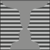

{'vase': 0.31, 'two faces': 0.69}


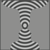

{'vase': 0.42, 'two faces': 0.58}


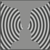

{'vase': 0.38, 'two faces': 0.62}


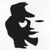

{"woman's face": 0.17, 'saxophonist': 0.83}


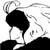

{'young woman': 0.65, 'old woman': 0.35}


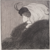

{'young woman': 0.6, 'old woman': 0.4}


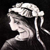

{'young woman': 0.53, 'old woman': 0.47}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


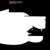

{'cat': 0.58, 'dog': 0.42}


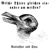

{'duck': 0.54, 'rabbit': 0.46}


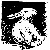

{'duck': 0.6, 'rabbit': 0.4}


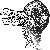

{'duck': 0.62, 'rabbit': 0.38}


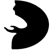

{'face grimacing': 0.1, 'begger sticking out their hands': 0.9}


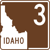

{'the state of Idaho': 1.0, 'face': 0.0}


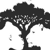

{'lion and gorilla': 1.0, 'tree': 0.0}


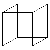

{'a cube seen from below': 0.37, 'a cube seen from above': 0.63}


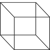

{'a cube seen from below': 0.35, 'a cube seen from above': 0.65}


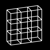

{'a cube seen from below': 0.41, 'a cube seen from above': 0.59}


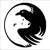

{'bird': 0.74, 'bear': 0.26}


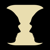

{'vase': 0.46, 'two faces': 0.54}


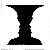

{'vase': 0.59, 'two faces': 0.41}


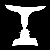

{'vase': 0.49, 'two faces': 0.51}


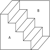

{'upright stairs': 0.89, 'sideways stairs': 0.11}


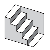

{'upright stairs': 0.85, 'sideways stairs': 0.15}


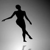

{'dancer spinning clockwise': 0.19, 'dancer spinning counter-clockwise': 0.81}


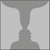

{'vase': 0.68, 'two faces': 0.32}


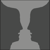

{'vase': 0.32, 'two faces': 0.68}


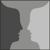

{'vase': 0.34, 'two faces': 0.66}


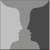

{'vase': 0.36, 'two faces': 0.64}


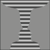

{'vase': 0.76, 'two faces': 0.24}


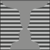

{'vase': 0.4, 'two faces': 0.6}


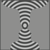

{'vase': 0.55, 'two faces': 0.45}


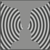

{'vase': 0.43, 'two faces': 0.57}


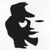

{"woman's face": 0.29, 'saxophonist': 0.71}


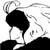

{'young woman': 0.48, 'old woman': 0.52}


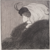

{'young woman': 0.41, 'old woman': 0.59}


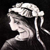

{'young woman': 0.45, 'old woman': 0.55}


In [ ]:
for model_id in ["HuggingFaceM4/idefics-9b", "HuggingFaceM4/idefics-9b-instruct"]:
  gc.collect()
  torch. cuda.empty_cache()
  ds = BistableImageDataset()
  prompt = "A photo of "
  exp_prefix = "original_images_"
  model, processor = get_model_and_processor(model_id)
  run_experiment_classification(ds, model_id, model, processor, prompt, results_dir, exp_prefix=exp_prefix)

### MplugOWL

install flash-attn first.


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LlamaTokenizer'. 
The class this function is called from is 'MplugOwlTokenizer'.
You are using the default legacy behaviour of the <class 'mplug_owl.tokenization_mplug_owl.MplugOwlTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
100%|██████████| 29/29 [00:04<00:00,  6.29it/s]


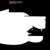

{'cat': 0.79, 'dog': 0.21}


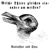

{'duck': 0.36, 'rabbit': 0.64}


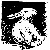

{'duck': 0.35, 'rabbit': 0.65}


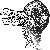

{'duck': 0.33, 'rabbit': 0.67}


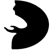

{'face grimacing': 0.29, 'begger sticking out their hands': 0.71}


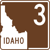

{'the state of Idaho': 1.0, 'face': 0.0}


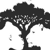

{'lion and gorilla': 1.0, 'tree': 0.0}


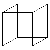

{'a cube seen from below': 0.33, 'a cube seen from above': 0.67}


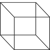

{'a cube seen from below': 0.32, 'a cube seen from above': 0.68}


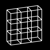

{'a cube seen from below': 0.34, 'a cube seen from above': 0.66}


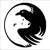

{'bird': 0.79, 'bear': 0.21}


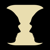

{'vase': 0.05, 'two faces': 0.95}


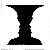

{'vase': 0.27, 'two faces': 0.73}


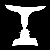

{'vase': 0.06, 'two faces': 0.94}


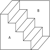

{'upright stairs': 0.93, 'sideways stairs': 0.07}


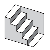

{'upright stairs': 0.91, 'sideways stairs': 0.09}


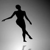

{'dancer spinning clockwise': 0.3, 'dancer spinning counter-clockwise': 0.7}


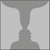

{'vase': 0.31, 'two faces': 0.69}


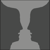

{'vase': 0.06, 'two faces': 0.94}


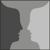

{'vase': 0.07, 'two faces': 0.93}


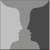

{'vase': 0.14, 'two faces': 0.86}


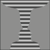

{'vase': 0.66, 'two faces': 0.34}


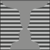

{'vase': 0.15, 'two faces': 0.85}


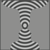

{'vase': 0.32, 'two faces': 0.68}


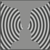

{'vase': 0.15, 'two faces': 0.85}


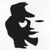

{"woman's face": 0.49, 'saxophonist': 0.51}


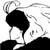

{'young woman': 0.31, 'old woman': 0.69}


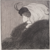

{'young woman': 0.37, 'old woman': 0.63}


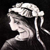

{'young woman': 0.28, 'old woman': 0.72}


In [ ]:
for model_id in  ["MAGAer13/mplug-owl-llama-7b"]:
  gc.collect()
  torch.cuda.empty_cache()
  ds = BistableImageDataset()
  prompt = "A photo of "
  exp_prefix = "original_images_"
  model, processor = get_model_and_processor(model_id)
  run_experiment_classification(ds, model_id, model, processor, prompt, results_dir, exp_prefix=exp_prefix)

### InstructBLIP

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:07<00:00,  4.05it/s]


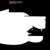

{'cat': 0.59, 'dog': 0.41}


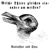

{'duck': 0.54, 'rabbit': 0.46}


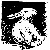

{'duck': 0.59, 'rabbit': 0.41}


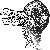

{'duck': 0.84, 'rabbit': 0.16}


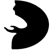

{'face grimacing': 0.61, 'begger sticking out their hands': 0.39}


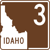

{'the state of Idaho': 0.99, 'face': 0.01}


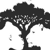

{'lion and gorilla': 0.98, 'tree': 0.02}


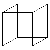

{'a cube seen from below': 0.54, 'a cube seen from above': 0.46}


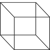

{'a cube seen from below': 0.54, 'a cube seen from above': 0.46}


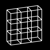

{'a cube seen from below': 0.54, 'a cube seen from above': 0.46}


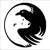

{'bird': 0.27, 'bear': 0.73}


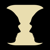

{'vase': 0.0, 'two faces': 1.0}


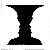

{'vase': 0.1, 'two faces': 0.9}


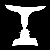

{'vase': 0.05, 'two faces': 0.95}


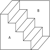

{'upright stairs': 0.22, 'sideways stairs': 0.78}


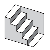

{'upright stairs': 0.21, 'sideways stairs': 0.79}


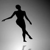

{'dancer spinning clockwise': 0.41, 'dancer spinning counter-clockwise': 0.59}


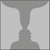

{'vase': 0.09, 'two faces': 0.91}


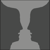

{'vase': 0.08, 'two faces': 0.92}


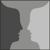

{'vase': 0.03, 'two faces': 0.97}


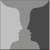

{'vase': 0.06, 'two faces': 0.94}


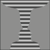

{'vase': 0.07, 'two faces': 0.93}


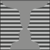

{'vase': 0.07, 'two faces': 0.93}


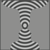

{'vase': 0.05, 'two faces': 0.95}


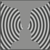

{'vase': 0.03, 'two faces': 0.97}


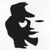

{"woman's face": 0.18, 'saxophonist': 0.82}


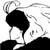

{'young woman': 0.36, 'old woman': 0.64}


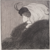

{'young woman': 0.38, 'old woman': 0.62}


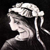

{'young woman': 0.26, 'old woman': 0.74}


In [ ]:
for model_id in  ["Salesforce/instructblip-flan-t5-xl"]:#model_to_ids["instructblip"]:
  gc.collect()
  torch.cuda.empty_cache()
  ds = BistableImageDataset()
  prompt = "A photo of "
  exp_prefix = "original_images_"
  model, processor = get_model_and_processor(model_id)
  run_experiment_classification(ds, model_id,model, processor, prompt, results_dir, exp_prefix=exp_prefix)

### BLIP2

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:32<00:00,  1.13s/it]


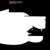

{'cat': 0.48, 'dog': 0.52}


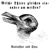

{'duck': 0.49, 'rabbit': 0.51}


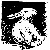

{'duck': 0.67, 'rabbit': 0.33}


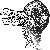

{'duck': 0.68, 'rabbit': 0.32}


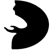

{'face grimacing': 0.1, 'begger sticking out their hands': 0.9}


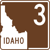

{'the state of Idaho': 1.0, 'face': 0.0}


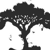

{'lion and gorilla': 1.0, 'tree': 0.0}


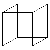

{'a cube seen from below': 0.39, 'a cube seen from above': 0.61}


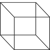

{'a cube seen from below': 0.4, 'a cube seen from above': 0.6}


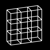

{'a cube seen from below': 0.39, 'a cube seen from above': 0.61}


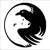

{'bird': 0.48, 'bear': 0.52}


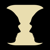

{'vase': 0.52, 'two faces': 0.48}


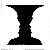

{'vase': 0.57, 'two faces': 0.43}


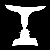

{'vase': 0.51, 'two faces': 0.49}


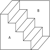

{'upright stairs': 0.48, 'sideways stairs': 0.52}


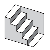

{'upright stairs': 0.33, 'sideways stairs': 0.67}


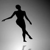

{'dancer spinning clockwise': 0.25, 'dancer spinning counter-clockwise': 0.75}


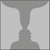

{'vase': 0.55, 'two faces': 0.45}


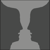

{'vase': 0.55, 'two faces': 0.45}


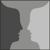

{'vase': 0.5, 'two faces': 0.5}


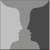

{'vase': 0.5, 'two faces': 0.5}


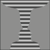

{'vase': 0.57, 'two faces': 0.43}


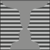

{'vase': 0.52, 'two faces': 0.48}


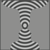

{'vase': 0.53, 'two faces': 0.47}


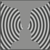

{'vase': 0.53, 'two faces': 0.47}


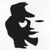

{"woman's face": 0.14, 'saxophonist': 0.86}


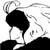

{'young woman': 0.68, 'old woman': 0.32}


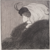

{'young woman': 0.69, 'old woman': 0.31}


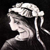

{'young woman': 0.66, 'old woman': 0.34}


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:32<00:00,  1.13s/it]


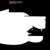

{'cat': 0.54, 'dog': 0.46}


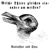

{'duck': 0.85, 'rabbit': 0.15}


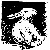

{'duck': 0.75, 'rabbit': 0.25}


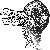

{'duck': 0.85, 'rabbit': 0.15}


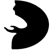

{'face grimacing': 0.11, 'begger sticking out their hands': 0.89}


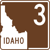

{'the state of Idaho': 1.0, 'face': 0.0}


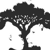

{'lion and gorilla': 1.0, 'tree': 0.0}


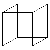

{'a cube seen from below': 0.39, 'a cube seen from above': 0.61}


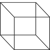

{'a cube seen from below': 0.38, 'a cube seen from above': 0.62}


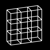

{'a cube seen from below': 0.38, 'a cube seen from above': 0.62}


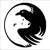

{'bird': 0.52, 'bear': 0.48}


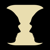

{'vase': 0.05, 'two faces': 0.95}


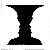

{'vase': 0.8, 'two faces': 0.2}


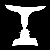

{'vase': 0.3, 'two faces': 0.7}


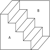

{'upright stairs': 0.27, 'sideways stairs': 0.73}


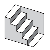

{'upright stairs': 0.4, 'sideways stairs': 0.6}


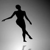

{'dancer spinning clockwise': 0.29, 'dancer spinning counter-clockwise': 0.71}


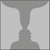

{'vase': 0.72, 'two faces': 0.28}


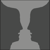

{'vase': 0.24, 'two faces': 0.76}


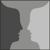

{'vase': 0.04, 'two faces': 0.96}


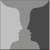

{'vase': 0.05, 'two faces': 0.95}


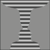

{'vase': 0.96, 'two faces': 0.04}


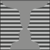

{'vase': 0.31, 'two faces': 0.69}


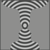

{'vase': 0.41, 'two faces': 0.59}


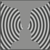

{'vase': 0.04, 'two faces': 0.96}


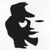

{"woman's face": 0.57, 'saxophonist': 0.43}


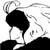

{'young woman': 0.63, 'old woman': 0.37}


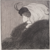

{'young woman': 0.75, 'old woman': 0.25}


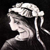

{'young woman': 0.73, 'old woman': 0.27}


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:37<00:00,  1.29s/it]


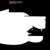

{'cat': 0.6, 'dog': 0.4}


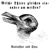

{'duck': 0.6, 'rabbit': 0.4}


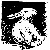

{'duck': 0.3, 'rabbit': 0.7}


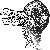

{'duck': 0.42, 'rabbit': 0.58}


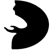

{'face grimacing': 0.74, 'begger sticking out their hands': 0.26}


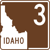

{'the state of Idaho': 0.97, 'face': 0.03}


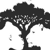

{'lion and gorilla': 0.98, 'tree': 0.02}


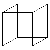

{'a cube seen from below': 0.44, 'a cube seen from above': 0.56}


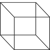

{'a cube seen from below': 0.47, 'a cube seen from above': 0.53}


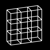

{'a cube seen from below': 0.44, 'a cube seen from above': 0.56}


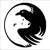

{'bird': 0.19, 'bear': 0.81}


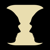

{'vase': 0.13, 'two faces': 0.87}


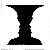

{'vase': 0.04, 'two faces': 0.96}


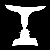

{'vase': 0.09, 'two faces': 0.91}


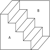

{'upright stairs': 0.15, 'sideways stairs': 0.85}


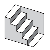

{'upright stairs': 0.17, 'sideways stairs': 0.83}


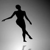

{'dancer spinning clockwise': 0.42, 'dancer spinning counter-clockwise': 0.58}


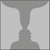

{'vase': 0.1, 'two faces': 0.9}


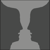

{'vase': 0.07, 'two faces': 0.93}


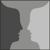

{'vase': 0.19, 'two faces': 0.81}


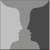

{'vase': 0.19, 'two faces': 0.81}


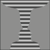

{'vase': 0.03, 'two faces': 0.97}


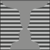

{'vase': 0.16, 'two faces': 0.84}


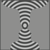

{'vase': 0.04, 'two faces': 0.96}


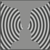

{'vase': 0.15, 'two faces': 0.85}


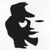

{"woman's face": 0.08, 'saxophonist': 0.92}


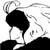

{'young woman': 0.33, 'old woman': 0.67}


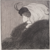

{'young woman': 0.29, 'old woman': 0.71}


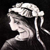

{'young woman': 0.36, 'old woman': 0.64}


In [ ]:
for model_id in ["Salesforce/blip2-opt-2.7b", "Salesforce/blip2-opt-6.7b", "Salesforce/blip2-flan-t5-xl"]:
  gc.collect()
  torch.cuda.empty_cache()
  ds = BistableImageDataset()
  prompt = "A photo of "
  exp_prefix = "original_images_"
  model, processor = get_model_and_processor(model_id)
  run_experiment_classification(ds, model_id, model, processor, prompt, results_dir, exp_prefix=exp_prefix)

## Generation

In [ ]:
def run_experiment_generation(ds, model_id, prompt, model, processor, results_dir, exp_prefix="", show_results=True):
  import torch
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # model, processor = get_model_and_processor(model_id)
  from tqdm import tqdm
  result = {"model_id": model_id, "image_transform": "none", "prompt": prompt, "outputs": {}}
  for item in tqdm(ds):
    with torch.no_grad():
      result["outputs"][item["image_id"]] = generate_from_item(item, model_id, model, processor, prompt)
  import json
  import os
  json.dump(result, open(os.path.join(results_dir, f"{exp_prefix}{model_id.replace('/','_')}.json"), "w"))
  if show_results:
    from IPython.display import display
    for image_id, out in result["outputs"].items():
      display(Image.open(os.path.join(ds.image_dir, image_id)).resize((50, 50)))
      print(out)
  del model
  torch.cuda.empty_cache()

#### Idefics-Instruct

In [ ]:
for model_id in ["HuggingFaceM4/idefics-9b", "HuggingFaceM4/idefics-9b-instruct"]:
  gc.collect()
  torch.cuda.empty_cache()
  ds = BistableImageDataset()
  prompt = "describe the image"
  exp_prefix = "original_images_generation"
  model, processor = get_model_and_processor(model_id)
  run_experiment_generation(ds, model_id, prompt, model, processor, results_dir, exp_prefix=exp_prefix)

#### LLaVA

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 29/29 [00:29<00:00,  1.02s/it]


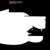


USER:describe the image.
ASSISTANT: The image features a white and black graphic of a vampire


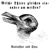


USER:describe the image.
ASSISTANT: The image features a black and white drawing of a duck's


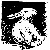


USER:describe the image.
ASSISTANT: The image features a black and white drawing of a duck. The


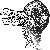


USER:describe the image.
ASSISTANT: The image features a black and white picture of a bird's head


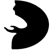


USER:describe the image.
ASSISTANT: The image features a black and white drawing of a hand holding a p


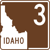


USER:describe the image.
ASSISTANT: The image features a brown and white sign with the word "Idaho


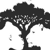


USER:describe the image.
ASSISTANT: The image features two men standing next to each other, with their faces


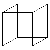


USER:describe the image.
ASSISTANT: The image features a black and white drawing of a square or a cube


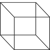


USER:describe the image.
ASSISTANT: The image features a large, square-shaped object, possibly a


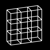


USER:describe the image.
ASSISTANT: The image features a black and white square design, possibly a logo or


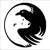


USER:describe the image.
ASSISTANT: The image features a black and white bird, possibly a raven,


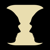


USER:describe the image.
ASSISTANT: The image features a black and white silhouette of a person'


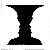


USER:describe the image.
ASSISTANT: The image features a black and white drawing of a person's face


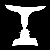


USER:describe the image.
ASSISTANT: The image features a black and white drawing of a person's face


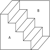


USER:describe the image.
ASSISTANT: The image is a black and white photo of a night sky. The


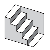


USER:describe the image.
ASSISTANT: The image features a stylized drawing of a set of stairs


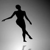


USER:describe the image.
ASSISTANT: The image features a silhouette of a woman's body,


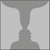


USER:describe the image.
ASSISTANT: The image features a man wearing a hat, with a large hat


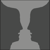


USER:describe the image.
ASSISTANT: The image features a close-up of a person's face,


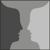


USER:describe the image.
ASSISTANT: The image features a close-up of two faces, one in black


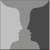


USER:describe the image.
ASSISTANT: The image features a close-up of two faces, one on the


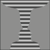


USER:describe the image.
ASSISTANT: The image features a close-up of two faces, one on the


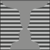


USER:describe the image.
ASSISTANT: The image features a close-up of a person's face,


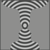


USER:describe the image.
ASSISTANT: The image features a close-up of a person's head,


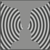


USER:describe the image.
ASSISTANT: The image features a close-up of a person's face,


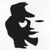


USER:describe the image.
ASSISTANT: The image features a black and white silhouette of a person,


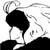


USER:describe the image.
ASSISTANT: The image is a black and white drawing of a person's face


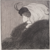


USER:describe the image.
ASSISTANT: The image features a woman wearing a black hat and a black coat


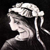


USER:describe the image.
ASSISTANT: The image features a woman wearing a bonnet and a white dress


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 29/29 [00:36<00:00,  1.24s/it]


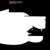


USER:describe the image.
ASSISTANT: The image features a black and white picture of a cat with its mouth


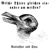


USER:describe the image.
ASSISTANT: The image features a black and white drawing of a bird, possibly a


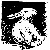


USER:describe the image.
ASSISTANT: The image features a black and white drawing of a baby duck.


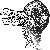


USER:describe the image.
ASSISTANT: The image is a black and white photograph of a bird's head


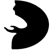


USER:describe the image.
ASSISTANT: The image is a black and white photo of a person's tor


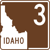


USER:describe the image.
ASSISTANT: The image features a brown and white sign with the number three on it


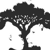


USER:describe the image.
ASSISTANT: The image is a black and white drawing of two men standing under a


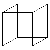


USER:describe the image.
ASSISTANT: The image is a black and white drawing of a cube. The cube


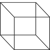


USER:describe the image.
ASSISTANT: The image is a black and white square, which is a geometric shape


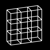


USER:describe the image.
ASSISTANT: The image features a black background with a white cube placed in the center


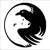


USER:describe the image.
ASSISTANT: The image features a black and white bird, possibly a raven,


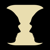


USER:describe the image.
ASSISTANT: The image features a black and white photo of two men's faces


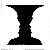


USER:describe the image.
ASSISTANT: The image is a black and white drawing of a person's head


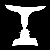


USER:describe the image.
ASSISTANT: The image features a black and white design of two faces, each with


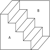


USER:describe the image.
ASSISTANT: The image is a black and white photograph of a dark room. The


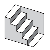


USER:describe the image.
ASSISTANT: The image features a staircase with a total of six steps.


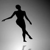


USER:describe the image.
ASSISTANT: The image features a silhouette of a woman, possibly a ball


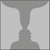


USER:describe the image.
ASSISTANT: The image features two silhouettes of people, one on the left


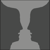


USER:describe the image.
ASSISTANT: The image is a black and white photograph of two faces, one on


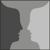


USER:describe the image.
ASSISTANT: The image is a black and white photo of two faces, one on


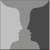


USER:describe the image.
ASSISTANT: The image is a black and white photograph of two faces, one on


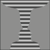


USER:describe the image.
ASSISTANT: The image is a black and white drawing of two faces, one on


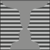


USER:describe the image.
ASSISTANT: The image features two silhouettes of people's heads, with


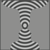


USER:describe the image.
ASSISTANT: The image features two faces, one on the left side and the other


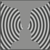


USER:describe the image.
ASSISTANT: The image features a unique design with two faces or heads, one on


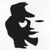


USER:describe the image.
ASSISTANT: The image is a black and white drawing of a woman's face


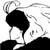


USER:describe the image.
ASSISTANT: The image is a black and white drawing of a woman's head


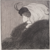


USER:describe the image.
ASSISTANT: The image is a black and white drawing of a woman wearing a


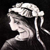


USER:describe the image.
ASSISTANT: The image is a black and white photograph of a woman wearing a


In [ ]:
# model_id = "llava-hf/llava-1.5-7b-hf"
for model_id in ["llava-hf/llava-1.5-7b-hf", "llava-hf/llava-1.5-13b-hf"]:
  gc.collect()
  torch.cuda.empty_cache()
  ds = BistableImageDataset()
  prompt = "describe the image."
  exp_prefix = "original_images_generation"
  model, processor = get_model_and_processor(model_id)
  run_experiment_generation(ds, model_id, prompt, model, processor, results_dir, exp_prefix=exp_prefix)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LlamaTokenizer'. 
The class this function is called from is 'MplugOwlTokenizer'.
100%|██████████| 29/29 [01:35<00:00,  3.30s/it]


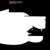

The image features a black and white photograph of a dog with its mouth open, looking directly at the camera. The dog is positioned in the center of the frame, with its head slightly turned to the left. The background is a darker shade of black, creating a contrast with the dog's white fur.


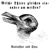

The image features a black and white drawing of a duck with a long neck and a beak. The duck is looking upwards, and its eyes are open. The duck is surrounded by a white background, creating a clean and simple appearance.


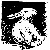

The image is a black and white drawing of a duckling sitting on a black background. The duckling is positioned in the center of the page, with its head and neck slightly raised. The duckling appears to be looking at something, possibly the viewer. The overall effect of the drawing is a simple and charming depiction of a duckling.


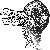

The image features a black and white drawing of a bird's head, specifically a goose's head, with a beak. The beak is the most prominent feature of the drawing, taking up most of the image. The head is positioned slightly to the left, and the beak is slightly curved. The overall appearance of the drawing is simple and elegant, capturing the essence of the bird's head.


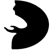

The image features a silhouette of a person with their mouth open, possibly in a surprised or surprised expression. The person is standing in a grassy area, with a tree in the background.


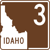

The image features a brown and white road sign with a brown background. The sign is located on a road, and it is positioned at the top of the image. The sign is a highway sign, indicating that it is a state highway. The sign is labeled "Idaho," indicating that it is located in the state of Idaho.


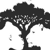

The image features a silhouette of a man and a woman standing together under a tree. They are facing each other, with the woman slightly leaning towards the man. The tree is positioned in the background, providing a natural backdrop for the couple.


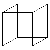

The image features a black and white drawing of a cube, with a white background. The cube is drawn in a simple, yet detailed manner, with a clear outline and a smooth surface. The cube is positioned in the center of the image, occupying most of the space.


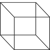

The image features a black and white drawing of a cube, with a square shape. The cube is positioned on a white background, creating a clear and simple design.


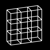

The image features a black and white square with a white grid pattern inside it. The square is filled with a grid of white squares, creating a visually striking and intricate design.


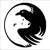

The image features a black and white drawing of a crow and a raven, both facing each other. The birds are positioned in a yin-yang symbol, with the raven on the left side and the crow on the right. The birds are drawn in a detailed and realistic style, with the raven appearing to be larger and more prominent than the crow.

The yin-yang symbol is a well-known symbol of balance and harmony, representing the interconnectedness of opposing forces in the universe. The presence of the birds in this symbol emphasizes the duality of nature and the importance of maintaining a balance between opposing forces


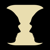

The image features a black and white silhouette of two people facing each other. They are both looking straight ahead, creating a sense of intimacy and connection between them. The silhouettes are placed on a white background, making the image visually striking and emphasizing the contrast between the figures and the background.


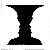

The image features a black and white drawing of a man's face, with a silhouette of a woman's face superimposed on top of it. The woman's face is slightly smaller than the man's, and it appears to be looking at the man's face. The man's face is positioned in the center of the image, while the woman's face is slightly to the right. The overall effect creates a sense of depth and perspective, as if the woman is looking at the man from a distance.


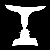

The image features a black and white silhouette of two people's faces, one on top of the other. The faces are facing each other, with the top face slightly larger than the bottom one. The silhouette is placed on a white background, creating a stark contrast between the faces and the background.


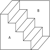

The image features a black and white photograph of a woman sitting on a couch, wearing a white dress. She is looking down, possibly lost in thought or contemplating something. The couch is situated in a room with a window, which is partially visible in the background.

There are several books scattered around the room, with some placed on the couch and others on the floor. A chair is also present in the room, positioned near the couch. The overall atmosphere of the scene is calm and relaxed, with the woman seemingly engrossed in her own thoughts.


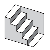

The image features a three-dimensional representation of a staircase, with a total of five steps. The staircase is made of metal and has a gray color. The steps are arranged in a zigzag pattern, with the first step being the largest and the last step being the smallest.

The staircase is situated in a room, with a wall on the left side and a window on the right side. The window is located near the top of the image, providing a view of the outside world.


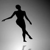

The image features a silhouette of a woman dancing in the air. She is standing on one leg, with her other leg extended behind her. The woman's body is in a graceful pose, showcasing her skill and balance. The silhouette is set against a black background, creating a dramatic and artistic effect.


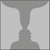

The image features a black and white photo of a man with a hat and a mustache. He is looking down, and his face is partially obscured by the hat. The hat is positioned in such a way that it creates a shadow on the man's face, making it appear as if he is looking down into a hole.

The man is standing in a room, with a chair visible in the background. The room appears to be empty, with no other people or objects present.


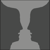

The image features a black and white silhouette of two faces, one on top of the other. The faces are facing each other, with the top face slightly larger than the bottom one. The silhouette is placed on a gray background, creating a contrasting effect.


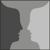

The image features a black and white drawing of a face, with one side of the face being completely black and the other side being completely white. The face is positioned in the center of the image, with the black side on the left and the white side on the right. The contrast between the two sides creates a striking and visually appealing effect.


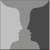

The image features a black and white drawing of a man and a woman facing each other. They are both wearing hats, with the man's hat being slightly larger than the woman's. The man's hat is positioned slightly above the woman's, creating a sense of depth and perspective.

The drawing is a silhouette, with the man and woman's faces and hats being the only visible parts of their bodies. The overall effect is a simple yet intriguing representation of the two individuals.


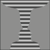

The image features a black and white striped pattern with a white hourglass shape in the center. The hourglass is surrounded by a black background, creating a contrasting effect.


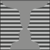

The image features a black and white striped pattern with a face in the middle. The face is divided into two halves, with one half appearing to be a mirror image of the other. The stripes are arranged in a checkerboard pattern, creating a visually interesting and unique design.


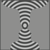

The image features a black and white photo of a woman with a white head. She is looking straight ahead, with her face in the center of the frame. Her hair is styled in a bun, and her eyes are visible. The background is a striped pattern, creating a visually interesting contrast with the woman's face.


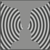

The image features a black and white optical illusion of a woman's face. The face is divided into two halves, with one half appearing to be a mirror image of the other. The woman's eyes are prominent, with one eye located on the left side of the image and the other on the right. The overall effect of the optical illusion is to create a sense of depth and movement, making the woman's face appear to be in motion or moving towards the viewer.


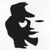

The image features a black and white drawing of a man's face, with a silhouette of a woman's face behind it. The man's face is in the foreground, while the woman's face is in the background. The man's face is slightly larger than the woman's, and both faces are positioned at different heights. The overall effect is a striking contrast between the two faces, creating a visually interesting and artistic composition.


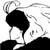

The image features a black and white drawing of a woman with a hat on her head. She is looking down, and her hair is covering her face. The woman is wearing a long dress, which extends down to her feet. The dress is also black and white, adding to the overall monochromatic appearance of the drawing.


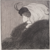

The image features a black and white drawing of a woman wearing a hat and a long black dress. She is standing in front of a wall, with her back turned towards the viewer. The hat is placed on her head, covering most of her face. The dress extends from her neck down to her feet, creating a long silhouette.

The woman is the main focus of the drawing, with the wall behind her serving as a backdrop. The scene is set in a room, with a chair visible in the background, possibly belonging to the woman.


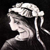

The image features a young girl with long, dark hair wearing a white dress and a white bonnet. She is looking down, possibly in thought or contemplation. The girl's face is partially obscured by the bonnet, creating a mysterious and intriguing appearance.

The scene is set in a room with a window, which can be seen in the background. The window is partially covered by a curtain, adding to the overall atmosphere of the image.


In [ ]:
gc.collect()
torch.cuda.empty_cache()
model_id = "MAGAer13/mplug-owl-llama-7b"
ds = BistableImageDataset()
prompt = "describe the image."
exp_prefix = "original_images_generation"
model, processor = get_model_and_processor(model_id)
run_experiment_generation(ds, model_id, prompt, model, processor, results_dir, exp_prefix=exp_prefix)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 29/29 [01:06<00:00,  2.31s/it]


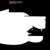

a black and white poster with an image of a bear with its mouth open


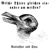

The image features a black-and-white drawing of a duck with its head open. It is located in the middle of the image, next to the words "Rainingen und Greifen", which refers to raining and geese.


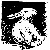

The image features a black and white drawing of a bird sitting in a square, with its beak open.


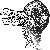

a black and white drawing of a duck head


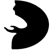

a silhouette of a woman with her hands in the air


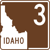

The image features a brown road sign with the number 3 on it. The sign is located in the middle of the image, with the number 3 prominently displayed.


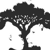

The logo features two giraffes and a tree in the background.


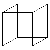

a black and white drawing of a cube


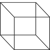

a black and white drawing of a cube


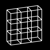

The image shows a white cube on a black background.


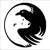

The image features a black and white yin and yang symbol with a crow and a bear in the center of the circle. The crow is visible on the left side of the circle, while the bear is visible on the right side of the circle.


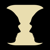

The image features a silhouette of two men facing each other, with their heads facing each other in a mirror-like fashion. There is a black background behind the silhouettes, which creates a striking contrast against the dark background. The silhouettes appear to be facing each other in a mirror-like fashion, with their heads facing each other in a mirror-like fashion. The silhouettes appear to be facing each other in a mirror-like fashion, with their heads facing each other in a mirror-like fashion. The silhouettes appear to be facing each other in a mirror-like fashion, with their heads facing each other in a mirror-like fashion. The silhouettes appear to be facing each other in a mirror-like fashion, with their heads facing each other in a mirror-like fashion. The silhouettes appear to be facing each other in a mirror-like fashion, with their heads facing each other in a mirror-like fashion. The silhouettes appear to be facing each other in a mirror-like fashion, with their heads fa

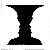

The image features a silhouette of a person's head in the shape of a vase.


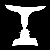

two silhouettes of heads facing each other on a black background


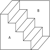

a black background with an airplane flying in the sky


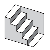

an isometric drawing of a set of stairs


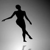

The image features a silhouette of a woman dancing on a grey background. The silhouette can be seen in different parts of the image, depending on where you look at it.


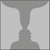

The image features a silhouette of a man with a hat on top of a grey background.


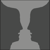

The image features a silhouette of a man with a cup in his hand.


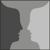

a silhouette of a man and a woman with their heads facing each other


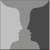

The image features a silhouette of two heads facing each other, with one head facing forward and the other facing backward.


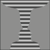

The image features a black and white vase with a striped pattern.


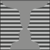

The image features a silhouette of a man with a beard and a striped background.


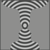

The image features a black and white silhouette of a person with a swirling pattern around his head.


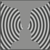

The image depicts two faces in the shape of a wave, with one facing forward and the other facing backward.


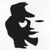

The image features a silhouette of a woman's face in black and white.


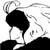

The image features a black and white drawing of a woman with a hat on her head. The woman is wearing a hat, which can be seen as a symbol of femininity in the image. The hat can be seen as a symbol of a woman's head covering, which can be seen as a symbol of a woman's head covering. The hat can be seen as a symbol of a woman's head covering, which can be seen as a symbol of a woman's head covering, which can be seen as a symbol of a woman's head covering, which can be seen as a symbol of a woman's head covering, which can be seen as a symbol of a woman's head covering, which can be seen as a symbol of a woman's head covering, which can be seen as a symbol of a woman's head covering, which can be seen as a symbol of a woman's head covering, which can be seen as a symbol of a woman's head covering, which can be seen as a symbol of a woman's head covering, which


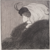

a black and white drawing of a woman wearing a fur coat and hat.


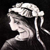

a black and white drawing of a girl wearing a hat


In [ ]:
gc.collect()
torch.cuda.empty_cache()
model_id = "Salesforce/instructblip-flan-t5-xl"
ds = BistableImageDataset()
prompt = "describe the image"
exp_prefix = "original_images_generation"
model, processor = get_model_and_processor(model_id)
run_experiment_generation(ds, model_id, prompt, model, processor, results_dir, exp_prefix=exp_prefix)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:39<00:00,  1.35s/it]


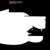

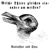

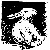

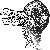

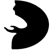

of a person in a circle


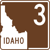

idaho 3


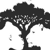

of the logo for the company


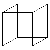

of a cube


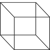

of a cube


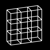

of the cube


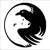

of the yin yang symbol


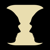

of two people in silhouette


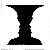

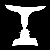

of two people silhouettes vector | price 1 credit usd $1


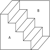

in the dark


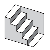

of a stair


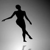

of a woman


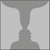

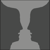

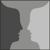

of a man and woman


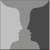

of a person in a mirror


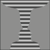

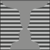

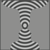

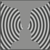

of the two faces in the image


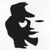

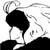

of a woman in a hat


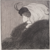

of the woman in the hat


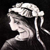

of the girl in the hat


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:45<00:00,  1.58s/it]


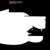

of a black cat with a white background


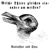

in the following words


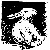

of a duck


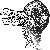

of a duck


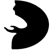

in one word


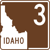

of idaho on the state highway sign


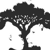

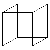

below using the words


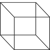

of a cube


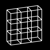

in words


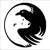

in one word


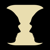

of two people facing each other


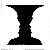

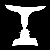

of two people silhouettes vector | price 1 credit usd $1


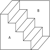

in your own words


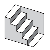

of a stairway


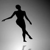

in one word


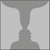

in the following words


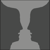

in the following words


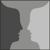

of two people facing each other


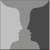

of two people facing each other


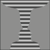

of a trophy


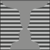

of a man with a hat


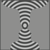

in terms of the following


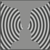

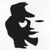

in the following words


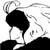

of a woman with a hat on her head


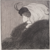

in one word


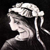

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 29/29 [01:02<00:00,  2.16s/it]


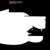

of a black and white poster with the words'returning space'


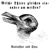

of a duck with a hat


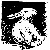

of a bird


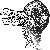

of a duck head


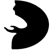

of a woman in a circle


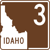

of idaho state highway 3


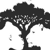

of a lion and a tree


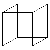

of a cube with a line


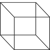

of a cube with four sides


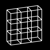

of a cube with squares on a black background


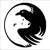

of a crow and a bear in a circle


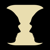

of two heads facing each other


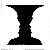

of a silhouette of a person


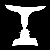

vector | price 1 credit usd $1


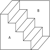

of a black background with a white airplane


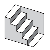

of a set of stairs


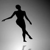

of a woman in silhouette


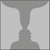

of a man with a hat on his head


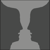

of a man with a hat on his head


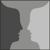

art clip art - preview image 81 007


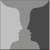

of two heads facing each other


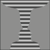

of a striped cup


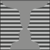

of a striped square with a head


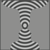

of a black and white swirling pattern


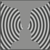

of two people in a black and white pattern


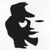

of a woman's face


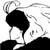

of a woman with a hat


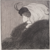

of a woman in a fur coat


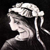

of a girl with a hat


In [ ]:
for model_id in  ["Salesforce/blip2-opt-2.7b", "Salesforce/blip2-opt-6.7b", "Salesforce/blip2-flan-t5-xl"]:
  gc.collect()
  torch.cuda.empty_cache()
  ds = BistableImageDataset()
  prompt = "describe the image"
  exp_prefix = "original_images_generation"
  model, processor = get_model_and_processor(model_id)
  run_experiment_generation(ds, model_id, prompt, model, processor, results_dir, exp_prefix=exp_prefix)

## Image Transformations

In [ ]:
for model_id in [mm for m in model_to_ids.values() for mm in m]:
  if 'clip' in model_id.lower():
    prompt = "A photo of {}"
  else:
    prompt = "A photo of "
  gc.collect()
  torch.cuda.empty_cache()
  print(model_id)
  model, processor = get_model_and_processor(model_id)
  for angle in list(range(0, 360, 10)):
    transform = lambda img: rotate_image(img.convert("RGBA"), angle)
    ds = BistableImageDataset(transform=transform)
    exp_prefix = f"rotation_images_generation_{angle}_"
    run_experiment_classification(ds, model_id, model, processor,  prompt, results_dir, exp_prefix=exp_prefix, show_results=False)
  # for gamma in [-1.,-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
  #   transform = lambda img: adjust_brightness(img.convert("RGBA"), gamma=gamma)
  #   ds = BistableImageDataset(transform=transform)
  #   exp_prefix = f"brightness_transform_images_classification_{gamma}_"
  #   run_experiment_classification(ds, model_id, model, processor,  prompt, results_dir, exp_prefix=exp_prefix, show_results=False)
  # for color in color_options:
  #   for gamma in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
  #     transform = lambda img: apply_color_tint(img.convert("RGBA"), color=color, gamma=gamma)
  #     ds = BistableImageDataset(transform=transform)
  #     exp_prefix = f"color_transform_images_generation_{color}_{gamma}_"
  #     run_experiment_classification(ds, model_id,  model, processor, prompt,results_dir, exp_prefix=exp_prefix, show_results=False)

openai/clip-vit-base-patch32


100%|██████████| 29/29 [00:00<00:00, 29.51it/s]


openai/clip-vit-base-patch16


100%|██████████| 29/29 [00:01<00:00, 28.94it/s]


laion/CLIP-ViT-B-32-laion2B-s34B-b79K


100%|██████████| 29/29 [00:01<00:00, 28.54it/s]


HuggingFaceM4/idefics-9b


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


HuggingFaceM4/idefics-9b-instruct


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


llava-hf/llava-1.5-7b-hf


/usr/local/lib/python3.10/dist-packages/transformers/models/llava/configuration_llava.py:103: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 29/29 [00:08<00:00,  3.56it/s]


llava-hf/llava-1.5-13b-hf


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 29/29 [00:10<00:00,  2.73it/s]


MAGAer13/mplug-owl-llama-7b
install flash-attn first.


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LlamaTokenizer'. 
The class this function is called from is 'MplugOwlTokenizer'.
You are using the default legacy behaviour of the <class 'mplug_owl.tokenization_mplug_owl.MplugOwlTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
100%|██████████| 29/29 [00:04<00:00,  6.64it/s]


Salesforce/instructblip-flan-t5-xl


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:06<00:00,  4.35it/s]


Salesforce/blip2-opt-2.7b


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:31<00:00,  1.08s/it]


Salesforce/blip2-opt-6.7b


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:31<00:00,  1.09s/it]


Salesforce/blip2-flan-t5-xl


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:36<00:00,  1.24s/it]


### Prompt Variation

In [ ]:
for model_id in [mm for m in model_to_ids.values() for mm in m]:
  gc.collect()
  torch.cuda.empty_cache()
  print(model_id)
  model, processor = get_model_and_processor(model_id)
  for prompt in ["A photo of ", "This is an image of ", "The image shows ", "An illustration of ", "I see a ", "What do you see? ", "This is a ", ]:
    if "clip" in model_id.lower():
      prompt += "{}"
    ds = BistableImageDataset()
    exp_prefix = f"prompt_variation_classification_{prompt}_"
    run_experiment_classification(ds, model_id, model, processor,  prompt, results_dir, exp_prefix=exp_prefix, show_results=False)


### Synonyms

In [ ]:
for model_id in [mm for m in model_to_ids.values() for mm in m]:
  gc.collect()
  torch.cuda.empty_cache()
  print(model_id)
  model, processor = get_model_and_processor(model_id)
  prompt = "A photo of "
  if "clip" in model_id.lower():
    prompt += "{}"
  ds = BistableImageDataset()
  annotations = []
  for item in ds:
    if len(item["synonyms"]) < 2:
      if len(item["synonyms"][0]) >= 2:
        item["labels"] = item["synonyms"][0][:2]
      else:
        continue
    else:
      item["labels"] = [item["synonyms"][0][0], item["synonyms"][1][0]]
    annotations.append(item)
  ds.annotations = annotations
  exp_prefix = f"synonyms_classification_{prompt}_"
  run_experiment_classification(ds, model_id, model, processor,  prompt, results_dir, exp_prefix=exp_prefix, show_results=False)

### Questions

In [ ]:
def run_experiment_question(ds, model_id, model, processor, results_dir, exp_prefix="", show_results=True):
  import torch
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # model, processor = get_model_and_processor(model_id)
  from tqdm import tqdm
  result = {"model_id": model_id, "image_transform": "none", "prompt": "N/A", "outputs": {}}
  for item in tqdm(ds):
    with torch.no_grad():
      result["outputs"][item["image_id"]] = generate_from_item(item, model_id, model, processor, item["question"], qa=True)
  import json
  import os
  json.dump(result, open(os.path.join(results_dir, f"{exp_prefix}{model_id.replace('/','_')}.json"), "w"))
  if show_results:
    from IPython.display import display
    for image_id, out in result["outputs"].items():
      display(Image.open(os.path.join(ds.image_dir, image_id)).resize((50, 50)))
      print(out)
  del model
  torch.cuda.empty_cache()

In [ ]:
for model_id in [mm for m in model_to_ids.values() for mm in m]:
  gc.collect()
  torch.cuda.empty_cache()
  model, processor = get_model_and_processor(model_id)
  if "clip" in model_id.lower():
    continue
  ds = BistableImageDataset(qa_only=True)
  exp_prefix = f"questions_generation_"
  run_experiment_question(ds, model_id, model, processor, results_dir, exp_prefix=exp_prefix, show_results=False)

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:24<00:00,  4.06s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:11<00:00,  1.95s/it]
/usr/local/lib/python3.10/dist-packages/transformers/models/llava/configuration_llava.py:103: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


install flash-attn first.


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LlamaTokenizer'. 
The class this function is called from is 'MplugOwlTokenizer'.
You are using the default legacy behaviour of the <class 'mplug_owl.tokenization_mplug_owl.MplugOwlTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
100%|██████████| 6/6 [00:03<00:00,  1.86it/s]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 6/6 [00:02<00:00,  2.08it/s]
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:04<00:00,  1.24it/s]
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:03<00:00,  1.74it/s]
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:16<00:00,  2.80s/it]


In [ ]:
!pip install flash-attention